In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import numpy as np
import scipy
from scipy.optimize import curve_fit

#### load data

In [2]:
input_csv = "vidro-1kHz-100mBias4.csv"

df = pd.read_csv(input_csv, comment='#', names=['x', 'y', 'p', 't'])
df.head()

,x,y,p,t
0,648,556,0,5312
1,645,556,1,5312
2,649,556,1,5312
3,653,556,1,5312
4,648,557,1,5312


### Filter (small region just to calculate phase per pixel) and see the ROI


Number of data points: 1371
            x    y  p        t
54722867  646  311  1  1100800
54722868  647  311  1  1100800
54722869  648  311  1  1100800
54722870  649  311  1  1100800
54722871  650  311  1  1100800
...       ...  ... ..      ...
54725501  649  178  1  1100850
54725502  651  178  1  1100850
54725503  648  183  0  1100850
54725505  649  182  1  1100850
54725506  651  182  1  1100850

[1371 rows x 4 columns]
Time range: 1100800 to 1100850
Filtered data:
     x    y  p        t
0  646  311  1  1100800
1  647  311  1  1100800
2  648  311  1  1100800
3  649  311  1  1100800
4  650  311  1  1100800
Number of events: 1371
Density array shape: (212075,)
Density indices shape: (1371,)
Max density index: 180734
Min density index: 29
Densities size: 212075
Density indices (first 10): [62050 62050 62050 62050 62050 62050 52700 52700 52700 52275]


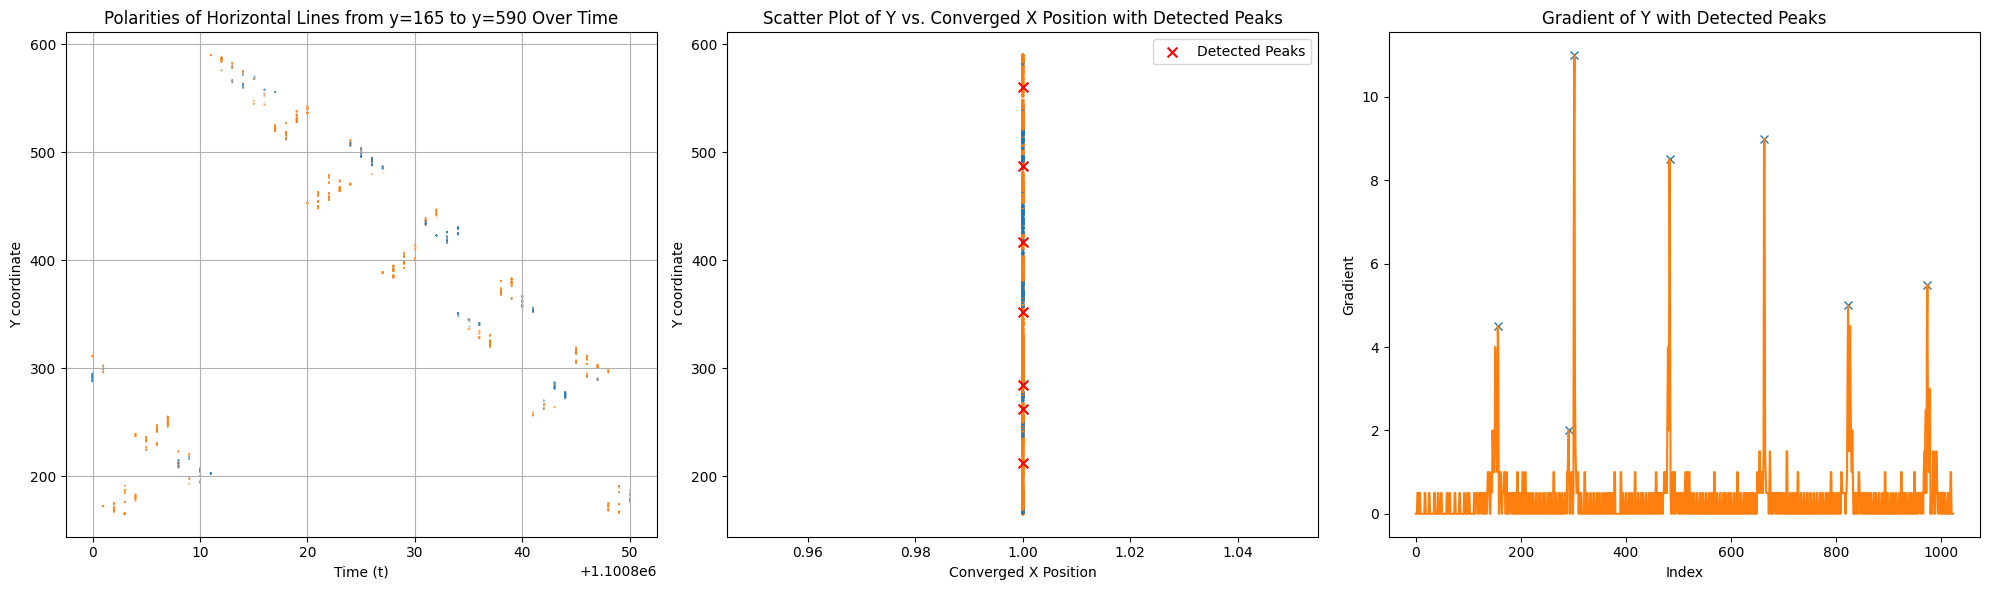

[212 262 284 352 417 487 561]


In [3]:
from polarityarea2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Define the parameters
tmin = 1100800
tmax = 1100850
ymin = 165
ymax = 590
xmin = 646
xmax = 651
polarity = None

# Filter the DataFrame for the specified horizontal line of pixels
line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

# Apply time filtering if specified
if tmin is not None:
    line_df = line_df[line_df['t'] >= tmin]
if tmax is not None:
    line_df = line_df[line_df['t'] <= tmax]

# Check if the filtered DataFrame is empty
if line_df.empty:
    print("No data points found for the given filters.")
else:
    print(f"Number of data points: {len(line_df)}")
    print(line_df)
    print(f"Time range: {line_df['t'].min()} to {line_df['t'].max()}")
    line_df.head()

# Sort the data based on y
x = line_df['x'].to_numpy()
y = line_df['y'].to_numpy()
t = line_df['t'].to_numpy()
p = line_df['p'].to_numpy()

idx = np.argsort(y)
x = x[idx]
y = y[idx]
t = t[idx]
p = p[idx]

# Separate the data based on polarity
yp = y[p == 1]
yn = y[p == 0]

# Calculate the gradient of yp
gradyp = np.gradient(yp)

# Find peaks in the gradient of the y data for polarity = 1
peaksidx, _ = find_peaks(gradyp, distance=10, prominence=2)

# Create the ysplit and phisplit arrays
ysplit = yp[peaksidx]
phisplit = np.arange(0, 2 * np.pi * len(ysplit), 2 * np.pi)

# Create a subplot grid with 1 row and 3 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# First plot: Using plot_lines_polarity_over_time
plot_lines_polarity_over_time(input_csv, xmin, xmax, ymin, ymax, tmin, tmax, polarity, ax=ax1)

# Second plot: Scatter plot of y vs. position (converged x)
colors = ["C0", "C1"]
colors_vec = [colors[p] for p in line_df['p']]

# Set all x positions to the same value (e.g., 1) to align them vertically
converged_x = np.ones(len(t))
ax2.scatter(converged_x, y, s=2, c=colors_vec)

# Overlay the detected peaks on the scatter plot
ax2.scatter(converged_x[peaksidx], yp[peaksidx], s=50, c="red", marker="x", label="Detected Peaks")

# Configure labels and title for the second plot
ax2.set_xlabel('Converged X Position')
ax2.set_ylabel('Y coordinate')
ax2.set_title('Scatter Plot of Y vs. Converged X Position with Detected Peaks')
ax2.legend()

# Third plot: Gradient of y with peaks
ax3.plot(peaksidx, abs(gradyp[peaksidx]), "x")
ax3.plot(gradyp)
ax3.set_title('Gradient of Y with Detected Peaks')
ax3.set_xlabel('Index')
ax3.set_ylabel('Gradient')

plt.tight_layout()
plt.show()

print(ysplit)


In [4]:
phisplit

array([ 0.        ,  6.28318531, 12.56637061, 18.84955592, 25.13274123,
       31.41592654, 37.69911184])

[0.         0.12566371 0.25132741 0.37699112 0.50265482 0.62831853
 0.75398224 0.87964594 1.00530965 1.13097336 1.25663706 1.38230077
 1.50796447 1.63362818 1.75929189 1.88495559 2.0106193  2.136283
 2.26194671 2.38761042 2.51327412 2.63893783 2.76460154 2.89026524
 3.01592895 3.14159265 3.26725636 3.39292007 3.51858377 3.64424748
 3.76991118 3.89557489 4.0212386  4.1469023  4.27256601 4.39822972
 4.52389342 4.64955713 4.77522083 4.90088454 5.02654825 5.15221195
 5.27787566 5.40353936 5.52920307 5.65486678 5.78053048 5.90619419
 6.03185789 6.1575216  0.         0.28559933 0.57119866 0.856798
 1.14239733 1.42799666 1.71359599 1.99919533 2.28479466 2.57039399
 2.85599332 3.14159265 3.42719199 3.71279132 3.99839065 4.28398998
 4.56958931 4.85518865 5.14078798 5.42638731 5.71198664 5.99758598
 0.         0.09239978 0.18479957 0.27719935 0.36959914 0.46199892
 0.5543987  0.64679849 0.73919827 0.83159806 0.92399784 1.01639762
 1.10879741 1.20119719 1.29359698 1.38599676 1.47839654 1.57079633

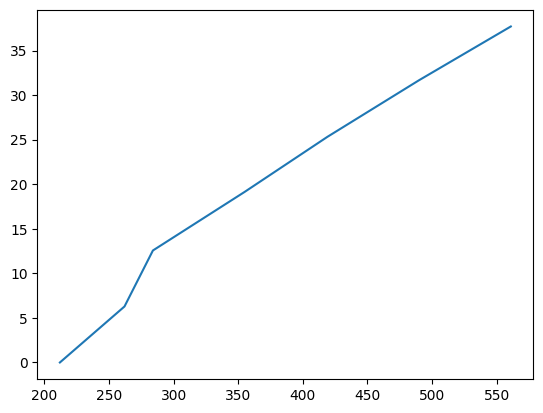

In [5]:
yroi = np.arange(ysplit[0], ysplit[-1] + 1)
phiroi = np.interp(yroi, ysplit, phisplit)
plt.plot(yroi, phiroi)
phiroi = np.mod(phiroi, 2 * np.pi) #between 0,2pi
print(phiroi)

### filter data (main data- bigger time period)

In [6]:
%matplotlib inline
# Define the parameters
tmin = 1100000
tmax = 2000000
ymin = yroi[0]
ymax = yroi[-1]


# Filter the DataFrame for the specified horizontal line of pixels
line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

# Apply time filtering if specified
if tmin is not None:
    line_df = line_df[line_df['t'] >= tmin]
if tmax is not None:
    line_df = line_df[line_df['t'] <= tmax]

# Check if the filtered DataFrame is empty
if line_df.empty:
    print("No data points found for the given filters.")
else:
    print(f"Number of data points: {len(line_df)}")
    print(line_df)
    print(f"Time range: {line_df['t'].min()} to {line_df['t'].max()}")
    line_df.head()


Number of data points: 20038874
            x    y  p        t
54683087  646  511  1  1100000
54683088  648  511  1  1100000
54683089  649  511  1  1100000
54683090  650  511  1  1100000
54683095  646  510  1  1100000
...       ...  ... ..      ...
99641804  648  291  1  2000000
99641805  647  299  0  2000000
99641806  649  299  0  2000000
99641807  651  299  0  2000000
99641809  646  299  1  2000000

[20038874 rows x 4 columns]
Time range: 1100000 to 2000000


### phase per pixel method application

yp: [299 294 294 ...  83  82  87]
phiroi: 3.8665755736489764
phase: [2.03778983 1.61325028 1.61325028 ... 1.01639762 0.92399784 1.38599676]
16668524
16668524


(0.0, 2000.0)

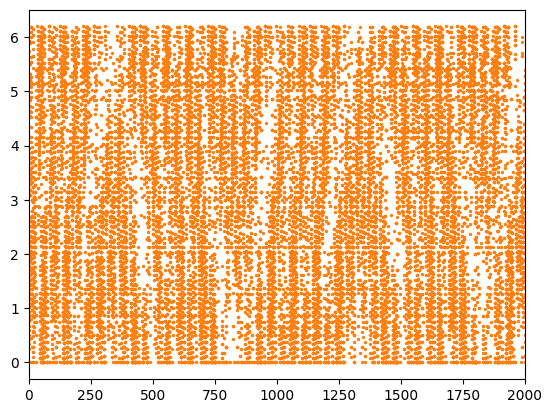

In [7]:

colors = ["C0", "C1"]

colors_vec = [colors[p] for p in line_df['p']]
x = line_df['x']
p = line_df['p']
t = line_df['t']
y = line_df['y']

x = np.array(x)
y = np.array(y)
p = np.array(p)
t = np.array(t)

idx = np.argsort(t)

x = x[idx]
y = y[idx]
t = t[idx]
p = p[idx]

t = t-t[0]

yp = y[p==1]
tp = t[p==1]
yn = y[p==0]

tp = tp-tp[0]

yp = yp-ymin

phase = np.array([phiroi[yi] for yi in yp])

print("yp:", yp)
print("phiroi:", phiroi[180])
print("phase:", phase)
##yp = np.mod(yp, pixels_per_period)
#yp = np.mod(yp, 84)

tp_uniques = np.unique(tp)

##phase = yp*phaseperpixel
print(len(tp))
print(len(phase))
plt.scatter(tp, phase, s=2, c="C1")
plt.xlim(0,2000)

### Calculation of phase (centroids)

In [8]:
tp_uniques = np.unique(tp)
centroid_y = []
tval_vec = []

for i,tval in enumerate(tp_uniques):
    yval = phase[tp==tval]
    ycomplex = np.cos(yval)+1j*np.sin(yval)

    ymean = np.angle(np.mean(ycomplex))

    
    #print(i, ymean)
    centroid_y.append(ymean)
    tval_vec.append(tval)

    if i > 5500:
        break

centroid_y = np.array(centroid_y)
tval_vec = np.array(tval_vec)


In [9]:
centroid_y,tval_vec

(array([ 1.66859489,  0.89671428,  0.36277787, ...,  2.75006224,
         2.69780714, -2.04294618]),
 array([   0,    1,    2, ..., 6417, 6418, 6419], dtype=int64))

### phases of events over time

(0.0, 2000.0)

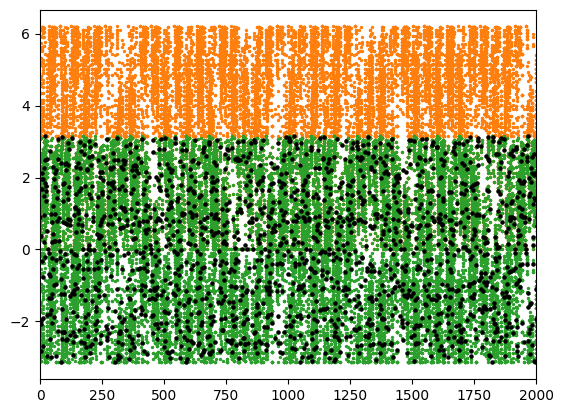

In [10]:
plt.scatter(tp, phase, s=2, c="C1")
plt.scatter(tp, np.mod(phase+np.pi, 2*np.pi)-np.pi, s=2, c="C2")
plt.scatter(tval_vec, centroid_y, s=5, c="k")
plt.xlim(0,2000)

### plot of the real and imaginary parts of complex numbers representing phase centroids

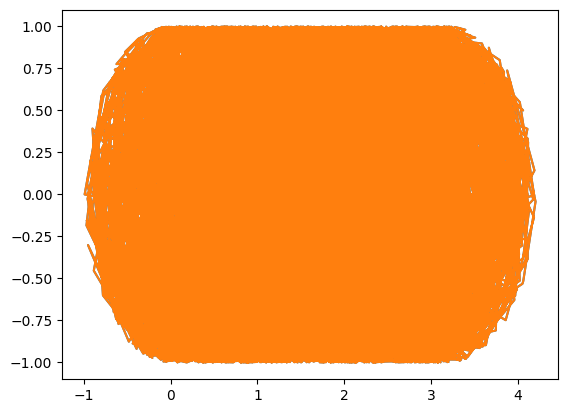

In [11]:
phase_complex = np.cos(centroid_y)+1j*np.sin(centroid_y)

#phase_complex = phase_complex[:100]

plt.plot(phase_complex.real+tval_vec/2000, phase_complex.imag, '-')
plt.plot(phase_complex.real+tval_vec/2000, phase_complex.imag, '-')


### Kalman filter to smooth the phase data derived from the centroid phases

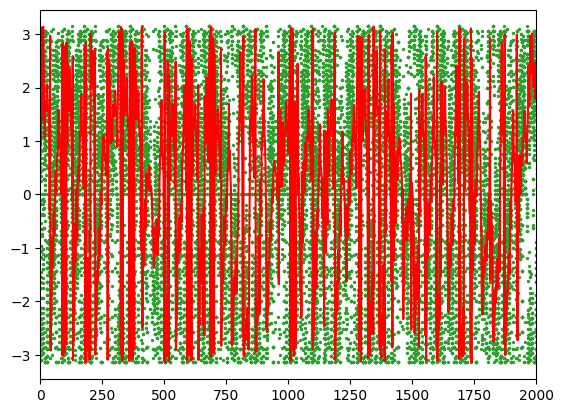

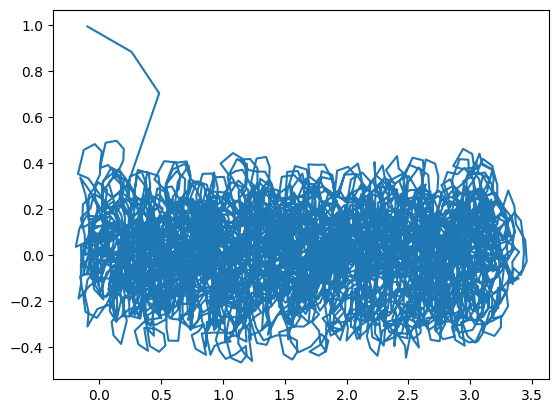

In [35]:
from kalman import KalmanTracking


Track = KalmanTracking()
Track.cov = 0.5 #Sets the initial covariance, representing the uncertainty in the initial state estimate.
Track.error_proc = 0.0001 #Sets the estimated process error, representing how much you expect the process to vary between steps.
Track.error_measurement = 0.01+0.01j #Sets the estimated measurement error, which includes both real and imaginary components.

complex_kalman = np.array([Track(c) for c in phase_complex])
phase_kalman = np.angle(complex_kalman)
#plt.plot(phase_complex.real+tval_vec/10000, phase_complex.imag, '.')
#plt.plot(phase_kalman.real+tval_vec/10000, phase_kalman.imag, '.')


plt.figure()
plt.scatter(tp, np.mod(phase+np.pi, 2*np.pi)-np.pi, s=2, c="C2")
#plt.scatter(tval_vec, centroid_y, s=5, c="k")
plt.plot(tval_vec, phase_kalman, c="r")
plt.xlim(0,2000)

plt.figure()
plt.plot(complex_kalman.real+tval_vec/2000, complex_kalman.imag, '-')


6.166067807662618

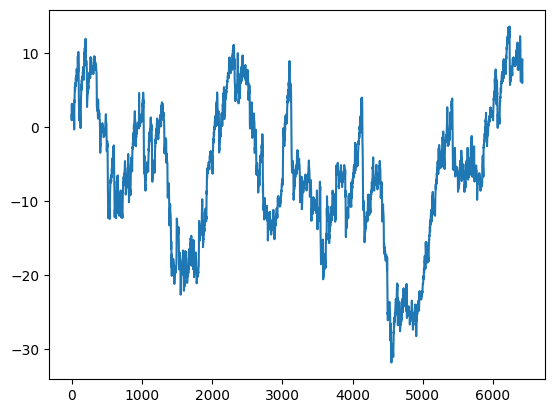

In [30]:
plt.plot(tval_vec, centroid_y)




np.ptp(np.diff(centroid_y)).max()


### Phase Unwrapping and Continuous Phase Analysis


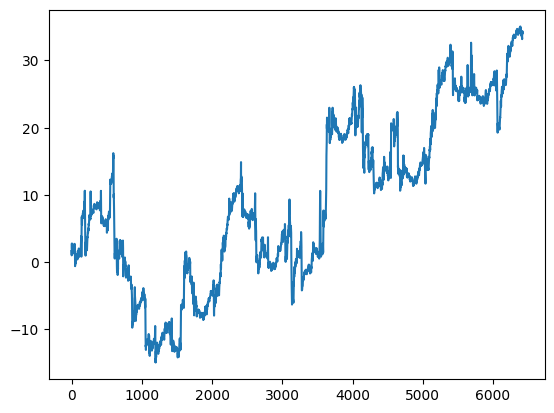

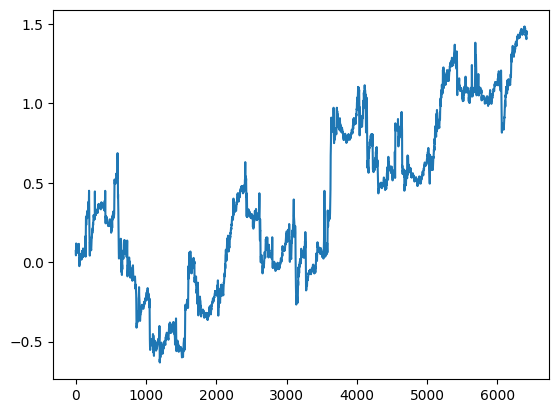

In [31]:
wavelength = 532e-9
centroid_y = np.unwrap(centroid_y)
centroid_y = np.unwrap(phase_kalman)

diff_phase = centroid_y - np.append([centroid_y[0]], np.diff(centroid_y))
plt.plot(tval_vec, centroid_y)
#plt.plot(tval_vec, diff_phase)
z = centroid_y/(2*np.pi)*wavelength/2

plt.figure()
plt.plot(tval_vec, z/1e-6)


### Displacement calc (nano)

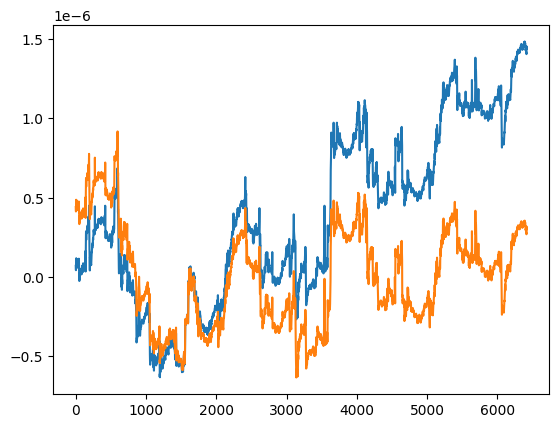

In [32]:
t_step = 1

t_interp = np.arange(tval_vec.min(), tval_vec.max(), t_step)
z_interp = np.interp(t_interp, tval_vec, z)

plt.plot(t_interp, z_interp)

z_detrend = scipy.signal.detrend(z_interp)
plt.plot(t_interp, z_detrend)


### FFT for finding main frequency of the signal

(0.0, 2000.0)

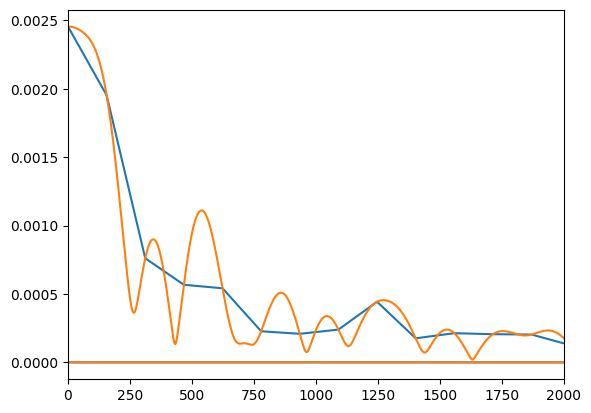

In [33]:
a = np.pad(z_interp, len(z_interp)*2)
a = np.pad(z_interp, 2**20-1)


ft = np.fft.fft(z_interp)
freqs = np.fft.fftfreq(len(ft), d=t_step*1e-6)

plt.plot(freqs, np.abs(ft))

ft = np.fft.fft(a)
freqs = np.fft.fftfreq(len(ft), d=t_step*1e-6)

plt.plot(freqs, np.abs(ft))

plt.xlim(0, 2000)

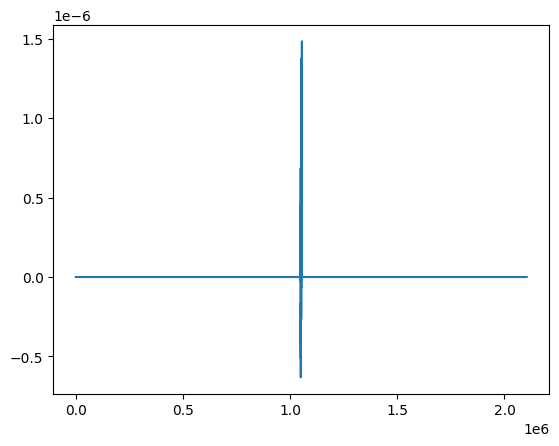

In [34]:
#a = np.pad(z_interp, len(z_interp)*2)

plt.plot(a)